# Using Image Embeddings from DINO VIT-B/16 to Cluster Images and Rertrieve Similarities from Curated Datasets

In [1]:
import base64
import io

from transformers import ViTFeatureExtractor, ViTModel
from dash import dcc, html, Input, Output, no_update
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from jupyter_dash import JupyterDash
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import supervision as sv
from PIL import Image
import numpy as np
import glob
import cv2

/home/tommysugg/FE/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Model 

In [2]:
feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

/home/tommysugg/FE/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Get Image Embeddings and Flatten Them

In [3]:
classes_paths = glob.glob('images/*/*.png')
classes = [str.split(i, '/')[1] for i in classes_paths]

states = []
images = []

images_paths = glob.glob('images/*/*.png')

for image_path in images_paths:
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)
    image = Image.fromarray(img_rgb)

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    state = last_hidden_states.detach().numpy()[0]
    states.append(state)

flattened_states = np.asarray([i.flatten() for i in states])

In [4]:
print(flattened_states.shape)
print(flattened_states[0])

(656, 151296)
[ 3.0297785  -0.10885861  3.2814877  ...  0.87867546  1.0380967
  1.8601133 ]


### Perform K Means Clustering

In [5]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(flattened_states)

### Perform PCA To Visualize Clusters

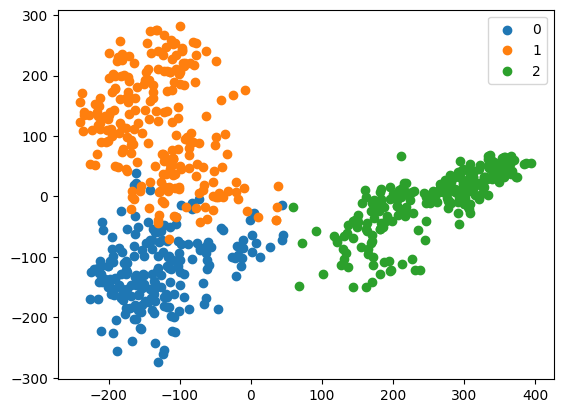

In [6]:
pca = PCA(2)
df = pca.fit_transform(flattened_states)

labels = kmeans.labels_

u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)
plt.legend()
plt.show()

### Visualize Clusters with TSNE

In [7]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(flattened_states)

def np_image_to_base64(im_matrix):
    im = Image.fromarray(im_matrix)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url

# Color for each digit
color_map = {
    "freshbanana": "#E52B50",
    "freshapples": "#9F2B68",
    "freshoranges": "#3B7A57"
}
colors = [color_map[l] for l in classes]

fig = go.Figure(data=[go.Scatter3d(
    x=projections[:, 0],
    y=projections[:, 1],
    z=projections[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=colors,
    )
)])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

app = JupyterDash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    im_matrix = images[num]
    im_url = np_image_to_base64(im_matrix)
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("Fruit type " + str(classes[num]), style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [8]:
app.run_server(mode='inline', debug=True)

Dash is running on http://127.0.0.1:8050/



### Predict Class for New Image

[1]


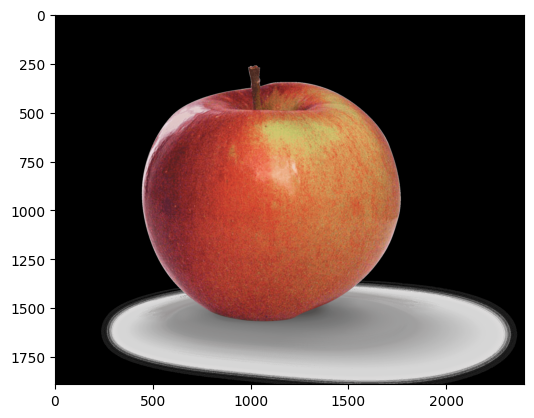

In [9]:
image_path = 'Fortune_NYAS-Apples2.png'
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img_rgb)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
state = last_hidden_states.detach().numpy()[0]

test_state = state.flatten()
pred = kmeans.predict(test_state.reshape(1, -1))

plt.imshow(image)
print(pred)

In [10]:
def normalize(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

def get_n_most_similar_images(cosine_sim_matrix: np.ndarray, image_index: int, similar_image_count: int) -> np.ndarray:
    similarities = cosine_sim_matrix[image_index]
    sorted_indices = np.argsort(similarities)[::-1]
    return sorted_indices[1:similar_image_count+1]

images_paths.append(image_path)
images.append(img_rgb)
flattened_states = np.vstack((flattened_states, test_state))

normalized_embeddings = normalize(flattened_states)
cosine_sim_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

IMAGE_INDEX = -1
SIMILAR_IMAGE_COUNT = 10

most_similar_indices = get_n_most_similar_images(cosine_sim_matrix=cosine_sim_matrix, image_index=IMAGE_INDEX, similar_image_count=SIMILAR_IMAGE_COUNT)
most_similar_cosine_values = cosine_sim_matrix[IMAGE_INDEX, most_similar_indices]

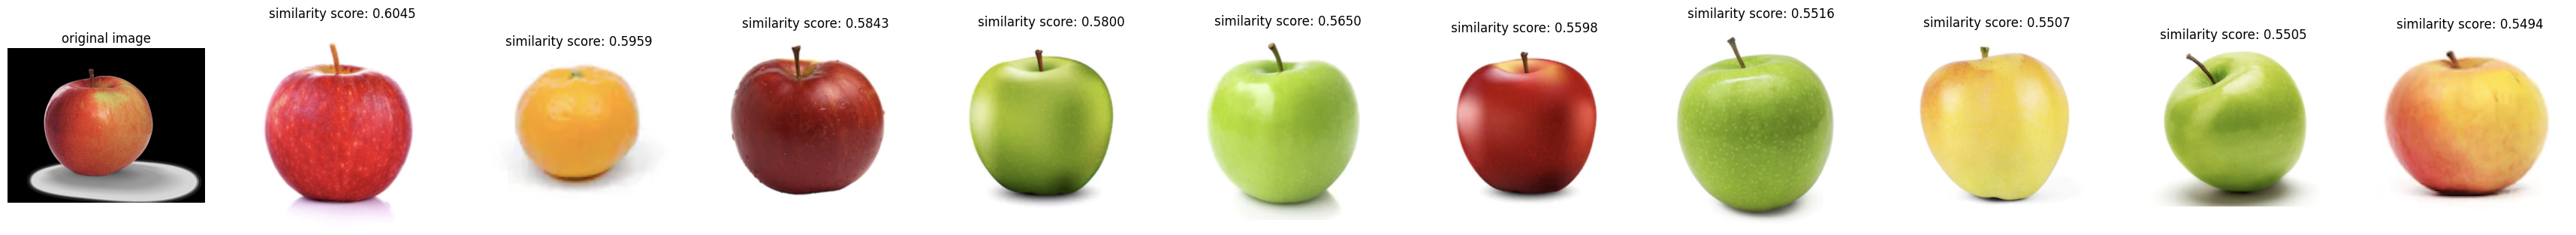

In [11]:
image_array = images[IMAGE_INDEX]
image_arrays = [image_array]
image_titles = ["original image"]

for image_index, similarity_score in zip(most_similar_indices, most_similar_cosine_values):
    image_array = images[image_index]
    image_arrays.append(image_array)
    image_titles.append(f"similarity score: {similarity_score:.4f}")
    
    
image_count = len(image_arrays)
grid_size = (1, image_count)
size = (4 * image_count, 4)
cmap = "gray"
nrows, ncols = grid_size

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)

for idx, ax in enumerate(axes.flat):
    if idx < len(image_arrays):
        if image_arrays[idx].ndim == 2:
            ax.imshow(image_arrays[idx], cmap=cmap)
        else:
            ax.imshow(image_arrays[idx])

        if image_titles is not None and idx < len(image_titles):
            ax.set_title(image_titles[idx])

    ax.axis("off")
plt.show()